<img src="../../../images/qiskit_header.png" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" align="middle">

# Terra 0.8 - Circuit API Updates

In this tutorial, we'll introduce three new components of the Terra circuit-building API added in the Terra 0.8 release. Their purpose is to facilitate circuit construction, reduce boilerplate, and aid reuse through composition and parameterization. These three new components are:

 1. [Optional register declarations](#1.-Optional-register-declarations)
 2. [Portable `Instruction`s and `CompositeGate` replacement](#2.-Portable-Instructions-and-CompositeGate-replacement)
 3. [Parameterized Circuit](#3.-Parameterized-circuits)


In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Optional registers

For circuits that require only a single register, register declarations can amount to unneeded overhead.
Terra 0.8 adds more concise syntax to create and build circuits without explicit register declaration.

### Registerless `QuantumCircuit` declaration

An alternate constructor has been added to `QuantumCircuit` that accepts one or two integers: the number of qubits (required), and the number of classical bits (optional).

In [2]:
qc = QuantumCircuit(3, 2)

This will create a quantum circuit equivalent to the following (still valid) circuit declaration:

In [3]:
qr = QuantumRegister(3, name='q')
cr = ClassicalRegister(2, name='c')
qc = QuantumCircuit(qr, cr)

Registers are created automatically and can be accessed through the circuit as needed.

In [4]:
print(qc.qregs)
print(qc.cregs)

[QuantumRegister(3, 'q')]
[ClassicalRegister(2, 'c')]


### Quantum/classical bit index-based addressing

In the spirit of register-less circuits, qubits and classical bits (clbits) can now be addressed directly by index, without a need for referencing a register.
In the following example, `bell.h(0)` attaches a Hadamard gate to the first quantum bit.

In [5]:
bell = QuantumCircuit(2, 2)
bell.h(0)
bell.cx(0, 1)
bell.measure([0,1], [0,1])

bell.draw()

The gate's argument types will determine if an index references a qubit or a clbit (e.g. `cx` expects `(qubit, qubit)`; `measure` expects `(qubit, clbit)`).
This syntax works with both forms of `QuantumCircuit` construction, and users can switch between register-based and index-based commands as convenient.

In circuits with multiple registers, index ordering will be set by the order in which registers were added to the circuit, and can be verified by inspecting the circuit's `qubits` and `clbits` properties.

In [6]:
qr1 = QuantumRegister(1, 'q1')
qr2 = QuantumRegister(1, 'q2')
cr = ClassicalRegister(2, 'c')
circuit = QuantumCircuit(qr2, qr1, cr)

print('Qubit ordering:', circuit.qubits)
print('Classical bit ordering:', circuit.clbits)

circuit.h([1,0])
circuit.measure(1, [0,1])
circuit.draw()

Qubit ordering: [Qubit(QuantumRegister(1, 'q2'), 0), Qubit(QuantumRegister(1, 'q1'), 0)]
Classical bit ordering: [Clbit(ClassicalRegister(2, 'c'), 0), Clbit(ClassicalRegister(2, 'c'), 1)]


## 2. Portable `Instruction`s and `CompositeGate` replacement

Starting with Terra 0.8, `Instruction` instances have become more portable and serve as the basis for composing re-usable circuit components through the new `append` method on `QuantumCircuit`s.

### Opaque gates

The `Gate` and `Instruction` constructors have been updated to accept an integer number of qubits (`num_qubits`) and an integer number of classical bits (`num_cbits`), which define the gate's quantum and classical width.

In [7]:
from qiskit.circuit import Gate

my_gate = Gate(name='my_gate', num_qubits=2, params=[])

An `append(instruction, qargs, cargs)` method has been added to the `QuantumCircuit` class, which takes an anonymous `Instruction` instance and attaches it to the circuit at the specified `qargs` and `cargs`.

In [8]:
qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.append(my_gate, [qr[0], qr[1]])
circ.append(my_gate, [qr[1], qr[2]])

circ.draw()

### Composite Gates

Composite gates and complex circuit components can now be constructed and managed as independent `QuantumCircuit`s and, through the `to_instruction` method, converted to `Instruction`s to be appended to a target circuit at a given location.

In [9]:
# Build a sub-circuit
sub_q = QuantumRegister(2)
sub_circ = QuantumCircuit(sub_q, name='sub_circ')
sub_circ.h(sub_q[0])
sub_circ.crz(1, sub_q[0], sub_q[1])
sub_circ.barrier()
sub_circ.iden(sub_q[1])
sub_circ.u3(1, 2, -2, sub_q[0])

# Convert to a gate and stick it into an arbitrary place in the bigger circuit
sub_inst = sub_circ.to_instruction()

q = QuantumRegister(3, 'q')
circ = QuantumCircuit(q)
circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.cx(qr[1], qr[2])
circ.append(sub_inst, [q[1], q[2]])

circ.draw()


Circuits are not immediately decomposed upon conversion `to_instruction` to allow circuit design at higher levels of abstraction.
When desired, or before compilation, sub-circuits will be decomposed via the `decompose` method.

In [10]:
decomposed_circ = circ.decompose() # Does not modify original circuit
decomposed_circ.draw()

## 3. Parameterized circuits

Parameterization is a common feature of many quantum algorithms, as well as a standard building block for constructing libraries of standard gates and subcircuits.

Terra 0.8 introduces a `Parameter` class that can be used to specify a placeholder wherever a numeric parameter can be used.

In the following example, we want to quickly construct a series of experiments that vary the angle of a global $R_z$ rotation over a set of entangled qubits.

In [11]:
from qiskit.circuit import Parameter

theta = Parameter('θ')

n = 5

qc = QuantumCircuit(5, 1)

qc.h(0)
for i in range(n-1):
    qc.cx(i, i+1)

qc.barrier()
qc.rz(theta, range(5))
qc.barrier()

for i in reversed(range(n-1)):
    qc.cx(i, i+1)
qc.h(0)
qc.measure(0, 0)

qc.draw()

We can inspect the circuit's parameters

In [12]:
print(qc.parameters)

{Parameter(θ)}


### Binding parameters to values

All circuit parameters must be bound before sending the circuit to a backend. This can be done in one of two ways:
- The `bind_parameters` method accepts a dictionary mapping `Parameter`s to values, and returns a new circuit with each parameter replaced by its corresponding value. Partial binding is supported, in which case the returned circuit will be parameterized by any `Parameter`s that were not mapped to a value.

In [13]:
import numpy as np

theta_range = np.linspace(0, 2 * np.pi, 128)

circuits = [qc.bind_parameters({theta: theta_val})
            for theta_val in theta_range]

print(circuits[-1].draw(line_length=120))
print(circuits[-1].parameters)

QiskitError: "Cannot bind Parameters (['θ']) not present in expression."

- `qiskit.execute` now accepts a `parameter_binds` keyword argument which, when specified as a list of dictionaries mapping `Parameter`s to values, will bind and execute a circuit on the backend for every mapping dictionary in the list.

In [14]:
from qiskit import BasicAer, execute

job = execute(qc,
              backend=BasicAer.get_backend('qasm_simulator'),
              parameter_binds=[{theta: theta_val} for theta_val in theta_range])

# Note: Bind labels are not presrved in executed experiments.
counts = [job.result().get_counts(i) for i in range(len(job.result().results))]


In the example circuit, we apply a global $R_z(\theta)$ rotation on a five-qubit entangled state, and so expect to see oscillation in qubit-0 at $5\theta$.

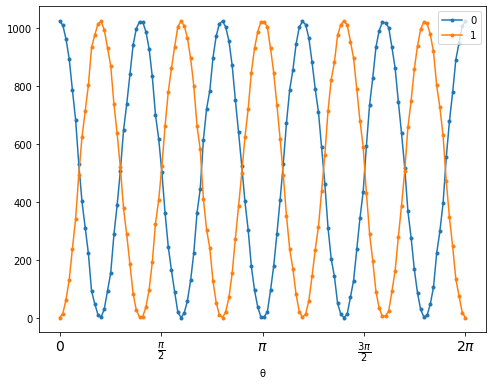

In [15]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.plot(theta_range, list(map(lambda c: c.get('0', 0), counts)), '.-', label='0')
ax.plot(theta_range, list(map(lambda c: c.get('1', 0), counts)), '.-', label='1') 

ax.set_xticks([i * np.pi / 2 for i in range(5)])
ax.set_xticklabels(['0', r'$\frac{\pi}{2}$', r'$\pi$', r'$\frac{3\pi}{2}$', r'$2\pi$'], fontsize=14)
ax.set_xlabel('θ')
ax.legend()

### Reducing compilation cost

Compiling over a parameterized circuit prior to binding can, in some cases, significantly reduce compilation time as compared to compiling over a set of bound circuits.

In [16]:
import time
from itertools import combinations
from qiskit.compiler import transpile, assemble
from qiskit.test.mock import FakeTokyo

start = time.time()
qcs = []

theta_range = np.linspace(0, 2*np.pi, 32)

for n in theta_range:
    qc = QuantumCircuit(5)

    for k in range(8):
        for i,j in combinations(range(5), 2):
            qc.cx(i,j)
        qc.rz(n, range(5))
        for i,j in combinations(range(5), 2):
            qc.cx(i,j)

    qcs.append(qc)
    
compiled_circuits = transpile(qcs, backend=FakeTokyo())
qobj = assemble(compiled_circuits, backend=FakeTokyo())

end = time.time()
print('Time compiling over set of bound circuits: ', end-start)

Time compiling over set of bound circuits:  17.536379098892212


In [17]:
start = time.time()
qc = QuantumCircuit(5)
theta = Parameter('theta')

for k in range(8):
    for i,j in combinations(range(5), 2):
        qc.cx(i,j)
    qc.rz(theta, range(5))
    for i,j in combinations(range(5), 2):
        qc.cx(i,j)

transpiled_qc = transpile(qc, backend=FakeTokyo())
qobj = assemble([transpiled_qc.bind_parameters({theta: n})
                 for n in theta_range], backend=FakeTokyo())
end = time.time()
print('Time compiling over parameterized circuit, then binding: ', end-start)

Time compiling over parameterized circuit, then binding:  2.1587467193603516


### Composition

Parameterized circuits can be composed like standard `QuantumCircuit`s.
Generally, when composing two parameterized circuits, the resulting circuit will be parameterized by the union of the parameters of the input circuits.

However, parameter names must be unique within a given circuit.
When attempting to add a parameter whose name is already present in the target circuit:
 - if the source and target share the same `Parameter` instance, the parameters will be assumed to be the same and combined
 - if the source and target have different `Parameter` instances, an error will be raised


In [18]:
phi = Parameter('phi')

sub_circ1 = QuantumCircuit(2, name='sc_1')
sub_circ1.rz(phi, 0)
sub_circ1.rx(phi, 1)

sub_circ2 = QuantumCircuit(2, name='sc_2')
sub_circ2.rx(phi, 0)
sub_circ2.rz(phi, 1)

qc = QuantumCircuit(4)
qr = qc.qregs[0]

qc.append(sub_circ1.to_instruction(), [qr[0], qr[1]])
qc.append(sub_circ2.to_instruction(), [qr[0], qr[1]])

qc.append(sub_circ2.to_instruction(), [qr[2], qr[3]])

print(qc.draw())

# The following raises an error: "QiskitError: 'Name conflict on adding parameter: phi'"
# phi2 = Parameter('phi')
# qc.u3(0.1, phi2, 0.3, 0)

        ┌────────────┐┌────────────┐
q_0: |0>┤0           ├┤0           ├
        │  sc_1(phi) ││  sc_2(phi) │
q_1: |0>┤1           ├┤1           ├
        ├────────────┤└────────────┘
q_2: |0>┤0           ├──────────────
        │  sc_2(phi) │              
q_3: |0>┤1           ├──────────────
        └────────────┘              


To insert a subcircuit under a different parameterization, the `to_instruction` method accepts an optional argument (`parameter_map`) which, when present, will generate instructions with the source parameter replaced by a new parameter.

In [19]:
p = Parameter('p')
qc = QuantumCircuit(3, name='oracle')
qc.rz(p, 0)
qc.cx(0, 1)
qc.rz(p, 1)
qc.cx(1, 2)
qc.rz(p, 2)

theta = Parameter('theta')
phi = Parameter('phi')
gamma = Parameter('gamma')

qr = QuantumRegister(9)
larger_qc = QuantumCircuit(qr)
larger_qc.append(qc.to_instruction({p: theta}), qr[0:3])
larger_qc.append(qc.to_instruction({p: phi}), qr[3:6])
larger_qc.append(qc.to_instruction({p: gamma}), qr[6:9])
print(larger_qc.draw())

print(larger_qc.decompose().draw())

         ┌────────────────┐
q1_0: |0>┤0               ├
         │                │
q1_1: |0>┤1 oracle(theta) ├
         │                │
q1_2: |0>┤2               ├
         └┬──────────────┬┘
q1_3: |0>─┤0             ├─
          │              │ 
q1_4: |0>─┤1 oracle(phi) ├─
          │              │ 
q1_5: |0>─┤2             ├─
         ┌┴──────────────┴┐
q1_6: |0>┤0               ├
         │                │
q1_7: |0>┤1 oracle(gamma) ├
         │                │
q1_8: |0>┤2               ├
         └────────────────┘
         ┌───────────┐                                    
q1_0: |0>┤ Rz(theta) ├──■─────────────────────────────────
         └───────────┘┌─┴─┐┌───────────┐                  
q1_1: |0>─────────────┤ X ├┤ Rz(theta) ├──■───────────────
                      └───┘└───────────┘┌─┴─┐┌───────────┐
q1_2: |0>───────────────────────────────┤ X ├┤ Rz(theta) ├
          ┌─────────┐                   └───┘└───────────┘
q1_3: |0>─┤ Rz(phi) ├───■──────────────────────────────

In [21]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright